# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

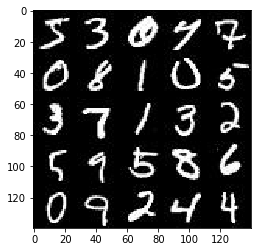

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

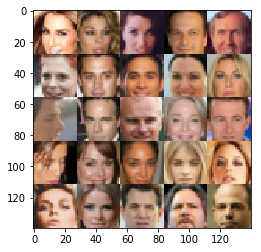

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    z_data = tf.placeholder(tf.float32, shape=[None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(z, alpha=0.01, name='leaky_relu'):
    return tf.maximum(alpha * z, z, name=name)

def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # convblock 1
        # shape = 28x28xC
        
        conv1_1 = tf.layers.conv2d(images, 64, kernel_size=3, strides=2, padding='same', activation=leaky_relu)
        # shape = 14x14x64
        
        conv1_2 = tf.layers.conv2d(conv1_1, 128, kernel_size=3, strides=2, padding='same', activation=leaky_relu)
        # shape = 7x7x128
        # max_pool1_3 = tf.layers.max_pooling2d(conv1_2, pool_size=2, strides=2, padding='valid')
        
        # convblock 2
        conv2_1 = tf.layers.conv2d(conv1_2, 256, kernel_size=3, strides=2, padding='same', activation=leaky_relu)
        # shape = 4x4x256
        # max_pool2_2 = tf.layers.max_pooling2d(conv2_1, pool_size=2, strides=2, padding='valid')
        
        # reshape
        conv2_1_flat = tf.reshape(conv2_1, shape=[-1, 256*4*4])
        conv2_1_flat_drop = tf.layers.dropout(conv2_1_flat, 0.5)
        
        # classifier block
        fc1 = tf.layers.dense(conv2_1_flat_drop, 256, activation=tf.nn.relu)
        fc1_drop = tf.layers.dropout(fc1, 0.5)
        # output
        logits = tf.layers.dense(fc1_drop, 1)
        proba = tf.nn.sigmoid(logits)

    return proba, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        fc1 = tf.layers.dense(z, 7*7*256, activation=leaky_relu)
        fc1_reshape = tf.reshape(fc1, shape=[-1, 7, 7, 256])
        # shape 7x7x256
        
        conv1 = tf.layers.conv2d_transpose(fc1_reshape, 128, kernel_size=3, strides=2, padding="same", activation=leaky_relu)
        # shape 14x14x128
        
        logits = tf.layers.conv2d_transpose(conv1, out_channel_dim, kernel_size=3, strides=2, padding="same")
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # generator
    g_model = generator(input_z, out_channel_dim)
    
    # discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    # loss values                       
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # g and d trainable vars
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    
    # optimize g and d
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
losses_global = []

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    losses = []
    
    # input placeholders
    input_real, input_fake, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # loss
    d_loss, g_loss = model_loss(input_real, input_fake, data_shape[3])

    # opimizer
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # [-0.5, 0.5] to [-1, 1]
                batch_images *= 2
                
                # random noise for generator
                gen_noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # opimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_fake: gen_noise})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_fake: gen_noise})
                
                train_loss_d = d_loss.eval({input_real: batch_images, input_fake: gen_noise})
                train_loss_g = g_loss.eval({input_fake: gen_noise})
                    
                if steps % 10 == 0:
                    print("Epoch {}/{} -".format(epoch_i+1, epochs),
                          "D_loss:{:.4f} |".format(train_loss_d),
                          "G_loss:{:.4f}".format(train_loss_g))
                    
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_fake, data_shape[3], data_image_mode)
                
                losses.append((train_loss_d, train_loss_g))

    global losses_global 
    losses_global = losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - D_loss:0.8631 | G_loss:0.5529
Epoch 1/2 - D_loss:0.2397 | G_loss:1.5610
Epoch 1/2 - D_loss:0.0242 | G_loss:3.8082
Epoch 1/2 - D_loss:1.2222 | G_loss:0.9636
Epoch 1/2 - D_loss:1.0759 | G_loss:0.7601
Epoch 1/2 - D_loss:0.2549 | G_loss:2.0470
Epoch 1/2 - D_loss:0.9369 | G_loss:0.7193
Epoch 1/2 - D_loss:1.2131 | G_loss:0.6385
Epoch 1/2 - D_loss:1.3157 | G_loss:0.4285
Epoch 1/2 - D_loss:0.9035 | G_loss:1.0740


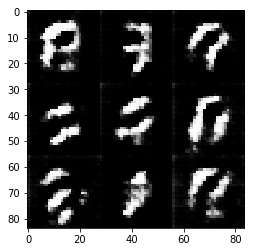

Epoch 1/2 - D_loss:1.0978 | G_loss:0.8228
Epoch 1/2 - D_loss:1.4479 | G_loss:0.4376
Epoch 1/2 - D_loss:1.5104 | G_loss:0.3380
Epoch 1/2 - D_loss:1.3670 | G_loss:0.3999
Epoch 1/2 - D_loss:1.5936 | G_loss:0.3035
Epoch 1/2 - D_loss:1.2197 | G_loss:0.5468
Epoch 1/2 - D_loss:1.1233 | G_loss:0.6631
Epoch 1/2 - D_loss:1.1325 | G_loss:0.7185
Epoch 1/2 - D_loss:0.8698 | G_loss:0.9878
Epoch 1/2 - D_loss:0.9745 | G_loss:0.9415


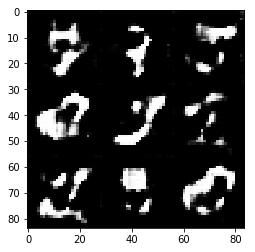

Epoch 1/2 - D_loss:0.8098 | G_loss:1.0257
Epoch 1/2 - D_loss:1.9054 | G_loss:0.2112
Epoch 1/2 - D_loss:1.9084 | G_loss:0.2554
Epoch 1/2 - D_loss:1.5136 | G_loss:0.4230
Epoch 1/2 - D_loss:0.6909 | G_loss:2.0452
Epoch 1/2 - D_loss:0.7908 | G_loss:2.0158
Epoch 1/2 - D_loss:1.0222 | G_loss:0.7647
Epoch 1/2 - D_loss:0.9844 | G_loss:0.7980
Epoch 1/2 - D_loss:1.9774 | G_loss:0.2354
Epoch 1/2 - D_loss:1.0415 | G_loss:0.8499


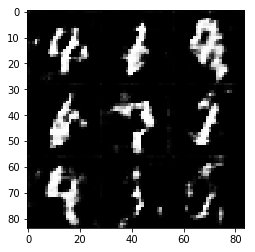

Epoch 1/2 - D_loss:0.7696 | G_loss:1.1035
Epoch 1/2 - D_loss:1.0763 | G_loss:0.6646
Epoch 1/2 - D_loss:0.9218 | G_loss:1.1113
Epoch 1/2 - D_loss:0.9194 | G_loss:0.9149
Epoch 1/2 - D_loss:1.6419 | G_loss:0.3364
Epoch 1/2 - D_loss:0.9628 | G_loss:0.8854
Epoch 1/2 - D_loss:1.3329 | G_loss:0.6561
Epoch 1/2 - D_loss:1.2223 | G_loss:0.6556
Epoch 1/2 - D_loss:1.3407 | G_loss:0.5077
Epoch 1/2 - D_loss:1.0117 | G_loss:0.8090


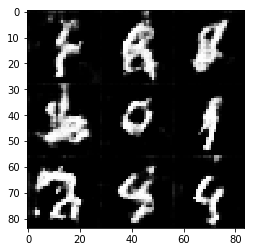

Epoch 1/2 - D_loss:1.7153 | G_loss:0.3748
Epoch 1/2 - D_loss:0.9373 | G_loss:0.8794
Epoch 1/2 - D_loss:0.8472 | G_loss:1.2927
Epoch 1/2 - D_loss:0.7335 | G_loss:1.9432
Epoch 1/2 - D_loss:0.5447 | G_loss:1.8407
Epoch 1/2 - D_loss:0.7854 | G_loss:1.3430
Epoch 1/2 - D_loss:0.8563 | G_loss:1.6330
Epoch 1/2 - D_loss:0.6923 | G_loss:1.6236
Epoch 1/2 - D_loss:0.8790 | G_loss:1.0767
Epoch 1/2 - D_loss:0.9143 | G_loss:1.1931


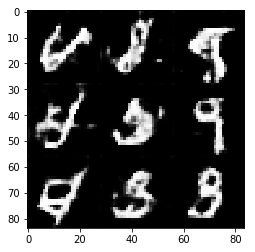

Epoch 1/2 - D_loss:0.8987 | G_loss:2.2384
Epoch 1/2 - D_loss:0.5351 | G_loss:2.0255
Epoch 1/2 - D_loss:0.7868 | G_loss:1.0244
Epoch 1/2 - D_loss:0.8463 | G_loss:1.7469
Epoch 1/2 - D_loss:0.8924 | G_loss:1.0414
Epoch 1/2 - D_loss:1.7550 | G_loss:0.4078
Epoch 1/2 - D_loss:1.2506 | G_loss:0.7354
Epoch 1/2 - D_loss:1.7147 | G_loss:0.3051
Epoch 1/2 - D_loss:1.1328 | G_loss:0.9282
Epoch 1/2 - D_loss:0.7738 | G_loss:1.7190


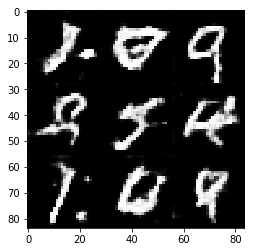

Epoch 1/2 - D_loss:0.7546 | G_loss:1.1950
Epoch 1/2 - D_loss:0.7279 | G_loss:1.4343
Epoch 1/2 - D_loss:1.1423 | G_loss:0.7650
Epoch 1/2 - D_loss:0.8065 | G_loss:1.0817
Epoch 1/2 - D_loss:1.0808 | G_loss:2.2915
Epoch 1/2 - D_loss:0.9691 | G_loss:0.7807
Epoch 1/2 - D_loss:1.0875 | G_loss:0.8676
Epoch 1/2 - D_loss:1.0668 | G_loss:0.8788
Epoch 1/2 - D_loss:0.8767 | G_loss:1.1331
Epoch 1/2 - D_loss:0.9310 | G_loss:1.3734


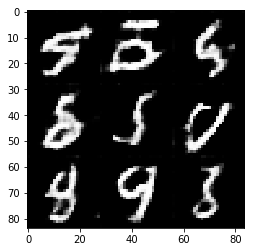

Epoch 1/2 - D_loss:1.0289 | G_loss:0.7641
Epoch 1/2 - D_loss:1.0147 | G_loss:0.9666
Epoch 1/2 - D_loss:1.0889 | G_loss:0.8191
Epoch 1/2 - D_loss:1.4809 | G_loss:0.4987
Epoch 1/2 - D_loss:1.4330 | G_loss:0.4969
Epoch 1/2 - D_loss:0.9306 | G_loss:1.0232
Epoch 1/2 - D_loss:0.9698 | G_loss:0.8577
Epoch 1/2 - D_loss:1.2598 | G_loss:0.6869
Epoch 1/2 - D_loss:1.2560 | G_loss:0.7682
Epoch 1/2 - D_loss:1.0307 | G_loss:0.7462


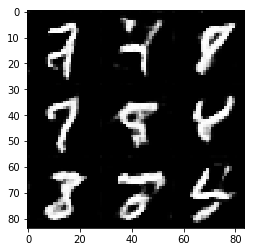

Epoch 1/2 - D_loss:0.8136 | G_loss:1.2579
Epoch 1/2 - D_loss:0.8193 | G_loss:2.0859
Epoch 1/2 - D_loss:0.9933 | G_loss:0.9562
Epoch 1/2 - D_loss:0.4892 | G_loss:1.5917
Epoch 1/2 - D_loss:0.8667 | G_loss:1.1481
Epoch 1/2 - D_loss:1.1125 | G_loss:0.7935
Epoch 1/2 - D_loss:0.7687 | G_loss:1.6581
Epoch 1/2 - D_loss:0.8894 | G_loss:1.1707
Epoch 1/2 - D_loss:1.2886 | G_loss:0.7365
Epoch 1/2 - D_loss:0.6865 | G_loss:1.5641


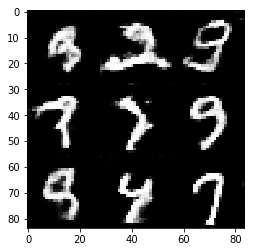

Epoch 1/2 - D_loss:0.8104 | G_loss:1.1540
Epoch 1/2 - D_loss:0.9782 | G_loss:0.9393
Epoch 1/2 - D_loss:0.9898 | G_loss:0.8180
Epoch 2/2 - D_loss:1.4104 | G_loss:0.5619
Epoch 2/2 - D_loss:1.2388 | G_loss:0.6430
Epoch 2/2 - D_loss:0.8043 | G_loss:1.1942
Epoch 2/2 - D_loss:1.4243 | G_loss:0.5969
Epoch 2/2 - D_loss:0.8107 | G_loss:2.0772
Epoch 2/2 - D_loss:0.7769 | G_loss:1.1687
Epoch 2/2 - D_loss:0.6448 | G_loss:2.1778


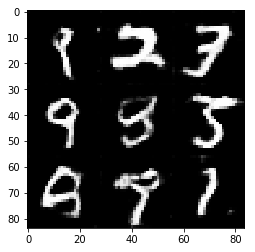

Epoch 2/2 - D_loss:0.8600 | G_loss:0.9205
Epoch 2/2 - D_loss:0.6444 | G_loss:1.5019
Epoch 2/2 - D_loss:0.9906 | G_loss:0.7620
Epoch 2/2 - D_loss:1.1264 | G_loss:0.7175
Epoch 2/2 - D_loss:0.5923 | G_loss:1.6615
Epoch 2/2 - D_loss:0.9615 | G_loss:0.9762
Epoch 2/2 - D_loss:1.2259 | G_loss:0.7886
Epoch 2/2 - D_loss:0.6942 | G_loss:1.4255
Epoch 2/2 - D_loss:0.8098 | G_loss:1.9844
Epoch 2/2 - D_loss:1.0838 | G_loss:0.7250


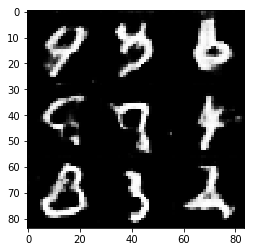

Epoch 2/2 - D_loss:0.7220 | G_loss:1.5508
Epoch 2/2 - D_loss:0.8383 | G_loss:1.2241
Epoch 2/2 - D_loss:0.5704 | G_loss:1.6439
Epoch 2/2 - D_loss:1.3187 | G_loss:0.6296
Epoch 2/2 - D_loss:1.1289 | G_loss:0.7250
Epoch 2/2 - D_loss:0.8559 | G_loss:0.9708
Epoch 2/2 - D_loss:0.6999 | G_loss:1.2325
Epoch 2/2 - D_loss:1.0722 | G_loss:0.8888
Epoch 2/2 - D_loss:0.7577 | G_loss:1.2733
Epoch 2/2 - D_loss:0.7731 | G_loss:1.0842


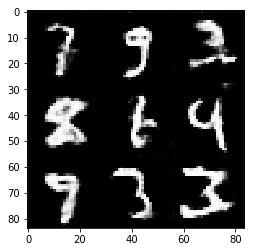

Epoch 2/2 - D_loss:0.6739 | G_loss:1.4098
Epoch 2/2 - D_loss:0.6583 | G_loss:1.5324
Epoch 2/2 - D_loss:1.2954 | G_loss:0.6627
Epoch 2/2 - D_loss:0.7214 | G_loss:1.3374
Epoch 2/2 - D_loss:0.7160 | G_loss:2.1563
Epoch 2/2 - D_loss:0.6046 | G_loss:1.4481
Epoch 2/2 - D_loss:1.3188 | G_loss:0.5932
Epoch 2/2 - D_loss:1.1124 | G_loss:0.9390
Epoch 2/2 - D_loss:0.8315 | G_loss:1.1268
Epoch 2/2 - D_loss:0.7250 | G_loss:2.3687


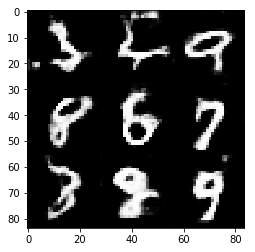

Epoch 2/2 - D_loss:1.1068 | G_loss:0.8674
Epoch 2/2 - D_loss:0.7527 | G_loss:1.5020
Epoch 2/2 - D_loss:0.6853 | G_loss:1.3819
Epoch 2/2 - D_loss:0.5779 | G_loss:1.6104
Epoch 2/2 - D_loss:0.8600 | G_loss:1.0236
Epoch 2/2 - D_loss:1.2631 | G_loss:0.5594
Epoch 2/2 - D_loss:0.6019 | G_loss:1.8106
Epoch 2/2 - D_loss:0.7741 | G_loss:1.0630
Epoch 2/2 - D_loss:0.7367 | G_loss:1.2289
Epoch 2/2 - D_loss:0.6501 | G_loss:2.2221


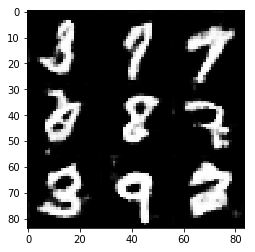

Epoch 2/2 - D_loss:0.4915 | G_loss:2.3730
Epoch 2/2 - D_loss:0.7911 | G_loss:1.0377
Epoch 2/2 - D_loss:1.2593 | G_loss:0.6742
Epoch 2/2 - D_loss:0.6561 | G_loss:2.0689
Epoch 2/2 - D_loss:0.8531 | G_loss:0.9736
Epoch 2/2 - D_loss:0.6506 | G_loss:1.3982
Epoch 2/2 - D_loss:0.5876 | G_loss:1.8864
Epoch 2/2 - D_loss:0.5715 | G_loss:1.9748
Epoch 2/2 - D_loss:1.0652 | G_loss:0.9050
Epoch 2/2 - D_loss:1.1986 | G_loss:0.6504


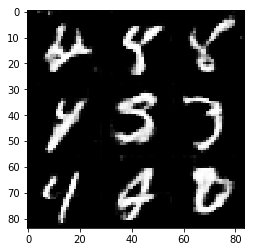

Epoch 2/2 - D_loss:0.7518 | G_loss:2.3606
Epoch 2/2 - D_loss:1.0458 | G_loss:0.7603
Epoch 2/2 - D_loss:0.4733 | G_loss:2.0962
Epoch 2/2 - D_loss:0.8893 | G_loss:0.9910
Epoch 2/2 - D_loss:1.0933 | G_loss:0.9815
Epoch 2/2 - D_loss:0.7768 | G_loss:1.4962
Epoch 2/2 - D_loss:0.8775 | G_loss:1.1987
Epoch 2/2 - D_loss:0.5859 | G_loss:1.6654
Epoch 2/2 - D_loss:0.8849 | G_loss:0.9407
Epoch 2/2 - D_loss:1.0562 | G_loss:0.7429


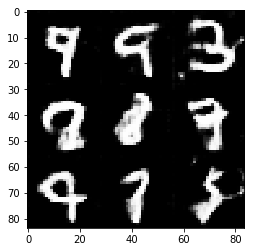

Epoch 2/2 - D_loss:1.1855 | G_loss:0.7011
Epoch 2/2 - D_loss:0.5272 | G_loss:1.6224
Epoch 2/2 - D_loss:1.2005 | G_loss:0.6634
Epoch 2/2 - D_loss:0.8557 | G_loss:1.1256
Epoch 2/2 - D_loss:0.8907 | G_loss:0.9813
Epoch 2/2 - D_loss:0.8118 | G_loss:1.0040
Epoch 2/2 - D_loss:1.0911 | G_loss:0.8446
Epoch 2/2 - D_loss:0.8187 | G_loss:1.1685
Epoch 2/2 - D_loss:0.8444 | G_loss:1.0273
Epoch 2/2 - D_loss:0.9401 | G_loss:1.0528


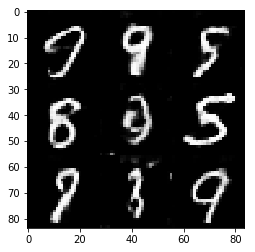

Epoch 2/2 - D_loss:0.8046 | G_loss:1.5061
Epoch 2/2 - D_loss:0.8036 | G_loss:2.2621
Epoch 2/2 - D_loss:0.7767 | G_loss:1.3060
Epoch 2/2 - D_loss:0.7437 | G_loss:1.0918
Epoch 2/2 - D_loss:1.0377 | G_loss:0.8693
Epoch 2/2 - D_loss:0.9182 | G_loss:0.9407
Epoch 2/2 - D_loss:0.4686 | G_loss:1.7795
Epoch 2/2 - D_loss:0.7747 | G_loss:1.1619
Epoch 2/2 - D_loss:1.4046 | G_loss:0.6789
Epoch 2/2 - D_loss:0.4698 | G_loss:2.0567


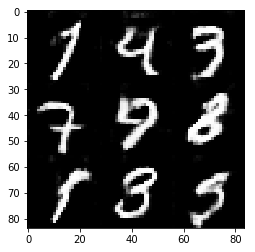

Epoch 2/2 - D_loss:0.8890 | G_loss:1.0328
Epoch 2/2 - D_loss:1.1786 | G_loss:0.6260
Epoch 2/2 - D_loss:0.9284 | G_loss:1.0489
Epoch 2/2 - D_loss:0.5381 | G_loss:1.6604
Epoch 2/2 - D_loss:1.2333 | G_loss:2.7179
Epoch 2/2 - D_loss:0.7888 | G_loss:1.2089
Epoch 2/2 - D_loss:0.7938 | G_loss:1.1987


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Show training loss graph

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

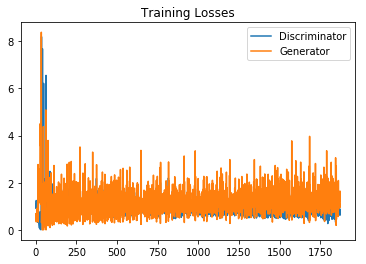

In [17]:
# plot losses for g and d for MNIST
fig, ax = plt.subplots()
losses = np.array(losses_global)

plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2 - D_loss:0.5833 | G_loss:0.8213
Epoch 1/2 - D_loss:0.0276 | G_loss:4.1292
Epoch 1/2 - D_loss:1.0955 | G_loss:0.5509
Epoch 1/2 - D_loss:0.0757 | G_loss:3.2570
Epoch 1/2 - D_loss:0.0565 | G_loss:3.4417
Epoch 1/2 - D_loss:0.6496 | G_loss:1.0388
Epoch 1/2 - D_loss:0.1280 | G_loss:4.3941
Epoch 1/2 - D_loss:0.0922 | G_loss:4.3880
Epoch 1/2 - D_loss:0.5735 | G_loss:7.4860
Epoch 1/2 - D_loss:0.1673 | G_loss:3.4279


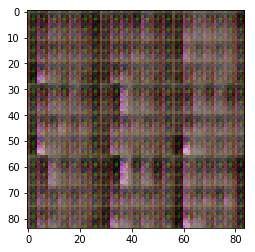

Epoch 1/2 - D_loss:0.2087 | G_loss:2.7113
Epoch 1/2 - D_loss:0.1507 | G_loss:3.4699
Epoch 1/2 - D_loss:0.0381 | G_loss:3.9379
Epoch 1/2 - D_loss:1.3392 | G_loss:0.8903
Epoch 1/2 - D_loss:0.8528 | G_loss:0.7535
Epoch 1/2 - D_loss:0.9746 | G_loss:0.9864
Epoch 1/2 - D_loss:0.8050 | G_loss:1.0730
Epoch 1/2 - D_loss:0.8254 | G_loss:0.9077
Epoch 1/2 - D_loss:1.2214 | G_loss:1.7601
Epoch 1/2 - D_loss:1.0252 | G_loss:0.8999


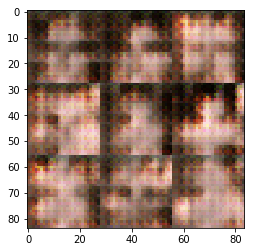

Epoch 1/2 - D_loss:1.0723 | G_loss:0.9377
Epoch 1/2 - D_loss:1.1646 | G_loss:0.8383
Epoch 1/2 - D_loss:1.4794 | G_loss:0.4875
Epoch 1/2 - D_loss:1.4289 | G_loss:0.6491
Epoch 1/2 - D_loss:1.2393 | G_loss:0.7349
Epoch 1/2 - D_loss:1.2908 | G_loss:0.7291
Epoch 1/2 - D_loss:1.3086 | G_loss:0.7129
Epoch 1/2 - D_loss:1.4068 | G_loss:0.6783
Epoch 1/2 - D_loss:1.1995 | G_loss:1.0657
Epoch 1/2 - D_loss:1.4636 | G_loss:0.4535


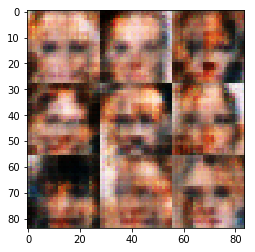

Epoch 1/2 - D_loss:1.2823 | G_loss:0.7073
Epoch 1/2 - D_loss:1.2743 | G_loss:0.6541
Epoch 1/2 - D_loss:1.3533 | G_loss:0.9319
Epoch 1/2 - D_loss:1.2850 | G_loss:0.7763
Epoch 1/2 - D_loss:1.3231 | G_loss:0.8288
Epoch 1/2 - D_loss:1.3275 | G_loss:0.7755
Epoch 1/2 - D_loss:1.3815 | G_loss:0.5775
Epoch 1/2 - D_loss:1.3854 | G_loss:0.5982
Epoch 1/2 - D_loss:1.3006 | G_loss:0.9247
Epoch 1/2 - D_loss:1.3320 | G_loss:0.5863


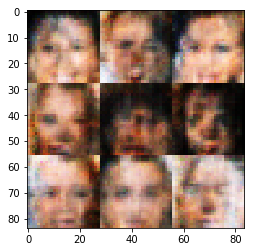

Epoch 1/2 - D_loss:1.3958 | G_loss:0.4792
Epoch 1/2 - D_loss:1.3503 | G_loss:0.6015
Epoch 1/2 - D_loss:1.3687 | G_loss:0.7093
Epoch 1/2 - D_loss:1.3115 | G_loss:0.7387
Epoch 1/2 - D_loss:1.3021 | G_loss:0.6794
Epoch 1/2 - D_loss:1.3742 | G_loss:0.7454
Epoch 1/2 - D_loss:1.7807 | G_loss:0.2423
Epoch 1/2 - D_loss:1.3390 | G_loss:0.7077
Epoch 1/2 - D_loss:1.3218 | G_loss:0.7281
Epoch 1/2 - D_loss:1.3110 | G_loss:0.7175


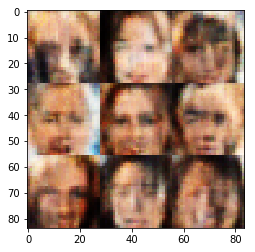

Epoch 1/2 - D_loss:1.3191 | G_loss:0.7649
Epoch 1/2 - D_loss:1.4088 | G_loss:0.4698
Epoch 1/2 - D_loss:1.2572 | G_loss:0.9542
Epoch 1/2 - D_loss:1.0592 | G_loss:0.7725
Epoch 1/2 - D_loss:1.2215 | G_loss:0.7451
Epoch 1/2 - D_loss:1.3251 | G_loss:0.7500
Epoch 1/2 - D_loss:1.3596 | G_loss:0.7374
Epoch 1/2 - D_loss:1.3618 | G_loss:0.6930
Epoch 1/2 - D_loss:1.3358 | G_loss:0.6202
Epoch 1/2 - D_loss:1.3740 | G_loss:0.7686


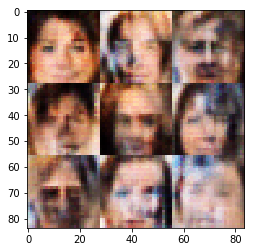

Epoch 1/2 - D_loss:1.3281 | G_loss:0.6633
Epoch 1/2 - D_loss:1.3889 | G_loss:0.6809
Epoch 1/2 - D_loss:1.3617 | G_loss:0.7439
Epoch 1/2 - D_loss:1.3655 | G_loss:0.7766
Epoch 1/2 - D_loss:1.4061 | G_loss:0.6737
Epoch 1/2 - D_loss:1.3961 | G_loss:0.5273
Epoch 1/2 - D_loss:1.4011 | G_loss:0.7905
Epoch 1/2 - D_loss:1.4516 | G_loss:0.5629
Epoch 1/2 - D_loss:1.4465 | G_loss:0.6013
Epoch 1/2 - D_loss:1.4283 | G_loss:0.6384


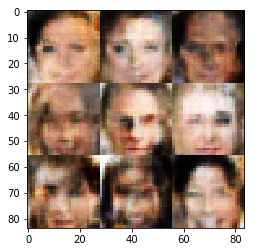

Epoch 1/2 - D_loss:1.2859 | G_loss:0.7667
Epoch 1/2 - D_loss:1.4449 | G_loss:0.7438
Epoch 1/2 - D_loss:1.1953 | G_loss:0.7539
Epoch 1/2 - D_loss:1.3231 | G_loss:0.7403
Epoch 1/2 - D_loss:1.4161 | G_loss:0.7443
Epoch 1/2 - D_loss:1.3387 | G_loss:1.0578
Epoch 1/2 - D_loss:2.3761 | G_loss:1.9123
Epoch 1/2 - D_loss:1.4348 | G_loss:1.0096
Epoch 1/2 - D_loss:1.3207 | G_loss:0.5696
Epoch 1/2 - D_loss:1.5901 | G_loss:1.2538


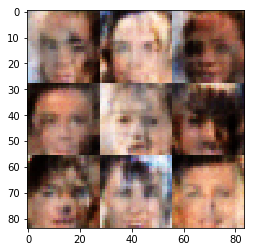

Epoch 1/2 - D_loss:1.9149 | G_loss:1.6272
Epoch 1/2 - D_loss:1.2681 | G_loss:1.1453
Epoch 1/2 - D_loss:1.5114 | G_loss:1.3215
Epoch 1/2 - D_loss:1.1841 | G_loss:0.8640
Epoch 1/2 - D_loss:1.4390 | G_loss:1.0069
Epoch 1/2 - D_loss:1.0577 | G_loss:1.0932
Epoch 1/2 - D_loss:1.4788 | G_loss:0.6783
Epoch 1/2 - D_loss:1.1969 | G_loss:0.8192
Epoch 1/2 - D_loss:1.3017 | G_loss:0.4777
Epoch 1/2 - D_loss:0.9538 | G_loss:0.6983


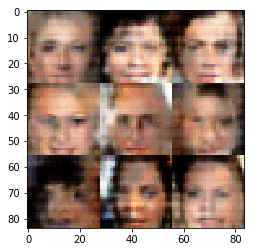

Epoch 1/2 - D_loss:1.4613 | G_loss:0.4519
Epoch 1/2 - D_loss:1.0810 | G_loss:1.1660
Epoch 1/2 - D_loss:2.7402 | G_loss:0.0855
Epoch 1/2 - D_loss:1.3872 | G_loss:0.5039
Epoch 1/2 - D_loss:1.3419 | G_loss:0.4708
Epoch 1/2 - D_loss:1.2259 | G_loss:0.6895
Epoch 1/2 - D_loss:1.3892 | G_loss:0.5734
Epoch 1/2 - D_loss:1.3082 | G_loss:0.5213
Epoch 1/2 - D_loss:1.7544 | G_loss:0.3298
Epoch 1/2 - D_loss:1.6061 | G_loss:0.3540


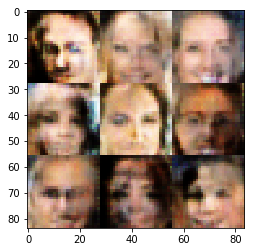

Epoch 1/2 - D_loss:1.5269 | G_loss:0.4146
Epoch 1/2 - D_loss:1.3500 | G_loss:0.6732
Epoch 1/2 - D_loss:1.4681 | G_loss:0.4573
Epoch 1/2 - D_loss:1.3459 | G_loss:0.6139
Epoch 1/2 - D_loss:1.3529 | G_loss:0.6929
Epoch 1/2 - D_loss:1.4244 | G_loss:0.5576
Epoch 1/2 - D_loss:1.1625 | G_loss:0.8319
Epoch 1/2 - D_loss:1.4379 | G_loss:0.5277
Epoch 1/2 - D_loss:0.8595 | G_loss:1.0935
Epoch 1/2 - D_loss:1.4257 | G_loss:0.6439


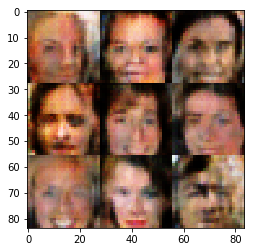

Epoch 1/2 - D_loss:1.4721 | G_loss:0.6827
Epoch 1/2 - D_loss:1.3019 | G_loss:0.7903
Epoch 1/2 - D_loss:1.3813 | G_loss:0.6347
Epoch 1/2 - D_loss:1.3358 | G_loss:0.7269
Epoch 1/2 - D_loss:1.3950 | G_loss:0.5391
Epoch 1/2 - D_loss:1.3970 | G_loss:0.7286
Epoch 1/2 - D_loss:1.4838 | G_loss:0.6112
Epoch 1/2 - D_loss:1.3600 | G_loss:0.6686
Epoch 1/2 - D_loss:1.2990 | G_loss:0.8464
Epoch 1/2 - D_loss:1.4350 | G_loss:0.5251


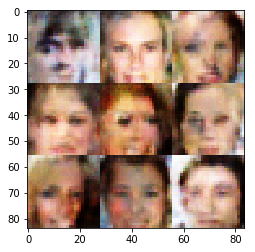

Epoch 1/2 - D_loss:1.3260 | G_loss:0.6128
Epoch 1/2 - D_loss:1.4777 | G_loss:0.4675
Epoch 1/2 - D_loss:0.8282 | G_loss:0.9532
Epoch 1/2 - D_loss:0.8397 | G_loss:1.1424
Epoch 1/2 - D_loss:1.2707 | G_loss:0.6706
Epoch 1/2 - D_loss:0.9957 | G_loss:1.4776
Epoch 1/2 - D_loss:0.9525 | G_loss:0.8149
Epoch 1/2 - D_loss:1.4932 | G_loss:0.4367
Epoch 1/2 - D_loss:1.3612 | G_loss:0.5408
Epoch 1/2 - D_loss:1.3392 | G_loss:0.6437


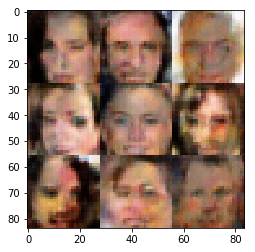

Epoch 1/2 - D_loss:1.1951 | G_loss:0.8108
Epoch 1/2 - D_loss:1.1446 | G_loss:0.6855
Epoch 1/2 - D_loss:1.2730 | G_loss:0.8101
Epoch 1/2 - D_loss:0.7567 | G_loss:1.2192
Epoch 1/2 - D_loss:1.4188 | G_loss:0.5325
Epoch 1/2 - D_loss:0.8621 | G_loss:1.3942
Epoch 1/2 - D_loss:1.5740 | G_loss:0.3547
Epoch 1/2 - D_loss:1.7736 | G_loss:0.3225
Epoch 1/2 - D_loss:0.8959 | G_loss:0.8419
Epoch 1/2 - D_loss:1.1190 | G_loss:1.3236


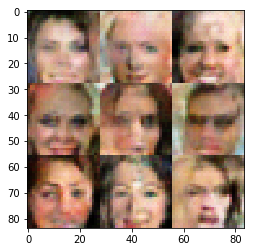

Epoch 1/2 - D_loss:0.9779 | G_loss:0.9834
Epoch 1/2 - D_loss:1.2344 | G_loss:0.5926
Epoch 1/2 - D_loss:0.2811 | G_loss:2.8959
Epoch 1/2 - D_loss:1.3089 | G_loss:0.6572
Epoch 1/2 - D_loss:1.4990 | G_loss:0.4910
Epoch 1/2 - D_loss:1.6391 | G_loss:2.1625
Epoch 1/2 - D_loss:1.6176 | G_loss:0.3945
Epoch 1/2 - D_loss:1.3294 | G_loss:0.6205
Epoch 1/2 - D_loss:1.1708 | G_loss:0.9353
Epoch 1/2 - D_loss:1.3607 | G_loss:1.3275


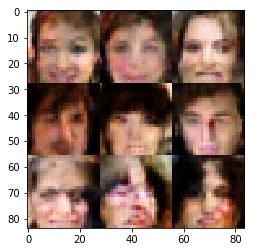

Epoch 1/2 - D_loss:1.1199 | G_loss:1.1652
Epoch 1/2 - D_loss:1.3607 | G_loss:0.5562
Epoch 1/2 - D_loss:1.3481 | G_loss:0.4862
Epoch 1/2 - D_loss:1.2583 | G_loss:0.6207
Epoch 1/2 - D_loss:1.3457 | G_loss:0.5869
Epoch 1/2 - D_loss:1.3672 | G_loss:0.4833
Epoch 1/2 - D_loss:1.0587 | G_loss:0.8839
Epoch 1/2 - D_loss:1.5819 | G_loss:0.3839
Epoch 1/2 - D_loss:1.4377 | G_loss:0.4916
Epoch 1/2 - D_loss:1.0861 | G_loss:0.7301


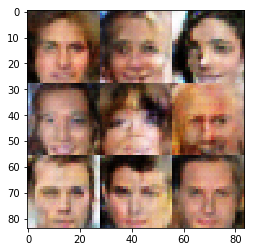

Epoch 1/2 - D_loss:2.2456 | G_loss:0.1587
Epoch 1/2 - D_loss:0.9324 | G_loss:0.9834
Epoch 1/2 - D_loss:1.6633 | G_loss:0.3489
Epoch 1/2 - D_loss:1.1346 | G_loss:0.9517
Epoch 1/2 - D_loss:1.4629 | G_loss:1.0887
Epoch 1/2 - D_loss:0.7418 | G_loss:1.0998
Epoch 1/2 - D_loss:1.4312 | G_loss:0.5138
Epoch 1/2 - D_loss:1.1316 | G_loss:0.8770
Epoch 1/2 - D_loss:1.0447 | G_loss:0.6942
Epoch 1/2 - D_loss:1.3201 | G_loss:0.5530


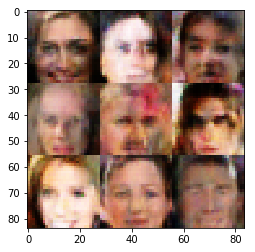

Epoch 1/2 - D_loss:1.3182 | G_loss:0.5864
Epoch 1/2 - D_loss:1.2432 | G_loss:1.6399
Epoch 1/2 - D_loss:1.1340 | G_loss:1.2479
Epoch 1/2 - D_loss:1.0474 | G_loss:1.2189
Epoch 1/2 - D_loss:1.6608 | G_loss:1.8579
Epoch 1/2 - D_loss:1.3617 | G_loss:0.5380
Epoch 1/2 - D_loss:1.2287 | G_loss:0.6474
Epoch 1/2 - D_loss:1.4704 | G_loss:1.7494
Epoch 1/2 - D_loss:1.2829 | G_loss:1.3595
Epoch 1/2 - D_loss:1.1375 | G_loss:0.9490


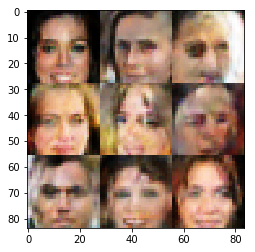

Epoch 1/2 - D_loss:0.8601 | G_loss:1.0873
Epoch 1/2 - D_loss:1.6297 | G_loss:0.4517
Epoch 1/2 - D_loss:0.7226 | G_loss:1.0645
Epoch 1/2 - D_loss:1.5272 | G_loss:0.4304
Epoch 1/2 - D_loss:1.0430 | G_loss:0.7960
Epoch 1/2 - D_loss:1.2078 | G_loss:0.7224
Epoch 1/2 - D_loss:0.8206 | G_loss:1.1401
Epoch 1/2 - D_loss:1.7148 | G_loss:0.3968
Epoch 1/2 - D_loss:1.3964 | G_loss:0.4662
Epoch 1/2 - D_loss:1.0707 | G_loss:0.6637


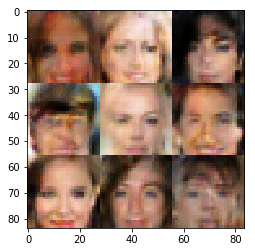

Epoch 1/2 - D_loss:1.1329 | G_loss:0.9835
Epoch 1/2 - D_loss:1.6632 | G_loss:0.3921
Epoch 1/2 - D_loss:1.3139 | G_loss:1.8897
Epoch 1/2 - D_loss:1.3678 | G_loss:0.5525
Epoch 1/2 - D_loss:2.1661 | G_loss:1.7774
Epoch 1/2 - D_loss:1.1601 | G_loss:0.7298
Epoch 1/2 - D_loss:2.0251 | G_loss:0.3567
Epoch 1/2 - D_loss:1.5683 | G_loss:2.0048
Epoch 1/2 - D_loss:1.4301 | G_loss:1.7131
Epoch 1/2 - D_loss:1.0827 | G_loss:0.6482


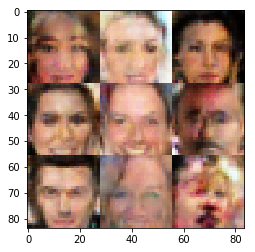

Epoch 1/2 - D_loss:1.4957 | G_loss:0.4435
Epoch 1/2 - D_loss:1.7908 | G_loss:0.2286
Epoch 1/2 - D_loss:1.3818 | G_loss:1.5898
Epoch 1/2 - D_loss:1.9070 | G_loss:0.3742
Epoch 1/2 - D_loss:1.5062 | G_loss:0.4471
Epoch 1/2 - D_loss:1.3807 | G_loss:0.5200
Epoch 1/2 - D_loss:2.1483 | G_loss:2.0554
Epoch 1/2 - D_loss:1.0054 | G_loss:0.9243
Epoch 1/2 - D_loss:1.2627 | G_loss:0.5135
Epoch 1/2 - D_loss:1.0108 | G_loss:0.8350


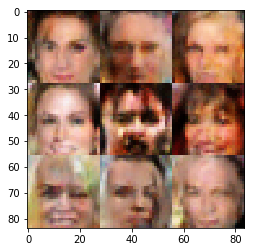

Epoch 1/2 - D_loss:2.5761 | G_loss:0.1875
Epoch 1/2 - D_loss:0.9961 | G_loss:0.7588
Epoch 1/2 - D_loss:1.5983 | G_loss:0.4379
Epoch 1/2 - D_loss:0.9579 | G_loss:0.9099
Epoch 1/2 - D_loss:1.1090 | G_loss:0.7842
Epoch 1/2 - D_loss:1.0790 | G_loss:0.7183
Epoch 1/2 - D_loss:0.9207 | G_loss:1.3902
Epoch 1/2 - D_loss:0.9827 | G_loss:1.0457
Epoch 1/2 - D_loss:2.3743 | G_loss:2.2012
Epoch 1/2 - D_loss:1.1019 | G_loss:0.7428


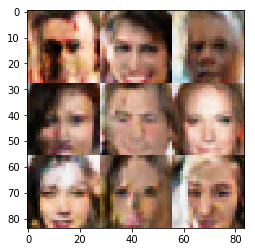

Epoch 1/2 - D_loss:0.7028 | G_loss:1.0093
Epoch 1/2 - D_loss:1.2782 | G_loss:0.6190
Epoch 1/2 - D_loss:0.6017 | G_loss:1.2678
Epoch 1/2 - D_loss:1.2443 | G_loss:0.6275
Epoch 1/2 - D_loss:1.5367 | G_loss:2.2227
Epoch 1/2 - D_loss:1.6670 | G_loss:1.7343
Epoch 1/2 - D_loss:0.4158 | G_loss:1.3709
Epoch 1/2 - D_loss:0.6878 | G_loss:1.2401
Epoch 1/2 - D_loss:1.0629 | G_loss:1.1775
Epoch 1/2 - D_loss:1.0233 | G_loss:1.4922


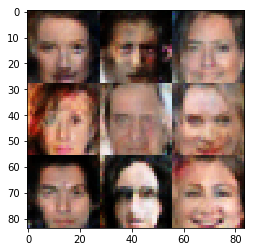

Epoch 1/2 - D_loss:2.1331 | G_loss:2.1383
Epoch 1/2 - D_loss:1.0378 | G_loss:0.9083
Epoch 1/2 - D_loss:1.3559 | G_loss:0.5596
Epoch 1/2 - D_loss:0.9721 | G_loss:1.1802
Epoch 1/2 - D_loss:0.5592 | G_loss:1.5530
Epoch 1/2 - D_loss:0.7382 | G_loss:1.1507
Epoch 1/2 - D_loss:0.9263 | G_loss:0.8109
Epoch 1/2 - D_loss:0.8908 | G_loss:1.3627
Epoch 1/2 - D_loss:0.3492 | G_loss:2.2139
Epoch 1/2 - D_loss:1.4095 | G_loss:0.5295


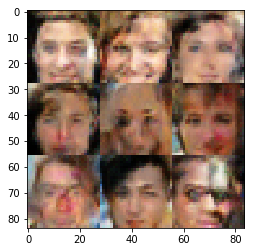

Epoch 1/2 - D_loss:0.2189 | G_loss:2.1120
Epoch 1/2 - D_loss:1.7829 | G_loss:0.3557
Epoch 1/2 - D_loss:0.2508 | G_loss:2.4182
Epoch 1/2 - D_loss:0.8814 | G_loss:0.8666
Epoch 1/2 - D_loss:1.5242 | G_loss:0.4980
Epoch 1/2 - D_loss:1.8407 | G_loss:0.3049
Epoch 1/2 - D_loss:0.9142 | G_loss:1.0092
Epoch 1/2 - D_loss:1.1722 | G_loss:2.1353
Epoch 1/2 - D_loss:0.8693 | G_loss:1.1821
Epoch 1/2 - D_loss:0.9551 | G_loss:1.2724


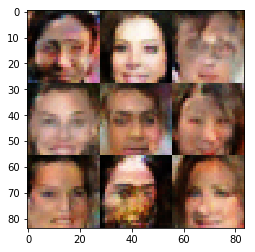

Epoch 1/2 - D_loss:0.5575 | G_loss:1.5238
Epoch 1/2 - D_loss:1.1505 | G_loss:0.9013
Epoch 1/2 - D_loss:1.3662 | G_loss:0.5450
Epoch 1/2 - D_loss:0.8033 | G_loss:1.3475
Epoch 1/2 - D_loss:1.3400 | G_loss:0.5959
Epoch 1/2 - D_loss:2.0728 | G_loss:0.2307
Epoch 1/2 - D_loss:1.0010 | G_loss:0.8039
Epoch 1/2 - D_loss:1.9152 | G_loss:0.3055
Epoch 1/2 - D_loss:1.5299 | G_loss:0.5251
Epoch 1/2 - D_loss:2.7500 | G_loss:0.1407


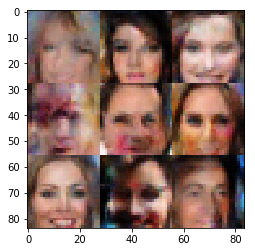

Epoch 1/2 - D_loss:1.1622 | G_loss:0.6518
Epoch 1/2 - D_loss:2.1024 | G_loss:0.2688
Epoch 1/2 - D_loss:1.2816 | G_loss:1.2236
Epoch 1/2 - D_loss:1.6913 | G_loss:0.3544
Epoch 1/2 - D_loss:0.9095 | G_loss:1.0358
Epoch 1/2 - D_loss:1.0273 | G_loss:0.7342
Epoch 1/2 - D_loss:0.9279 | G_loss:1.4315
Epoch 1/2 - D_loss:1.0970 | G_loss:0.8500
Epoch 1/2 - D_loss:1.4691 | G_loss:0.5043
Epoch 1/2 - D_loss:1.1258 | G_loss:0.7218


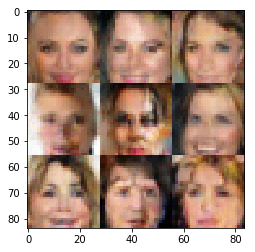

Epoch 1/2 - D_loss:1.6849 | G_loss:0.3868
Epoch 1/2 - D_loss:0.9509 | G_loss:0.9418
Epoch 1/2 - D_loss:1.8148 | G_loss:0.4254
Epoch 1/2 - D_loss:0.9964 | G_loss:0.8216
Epoch 1/2 - D_loss:1.2622 | G_loss:1.0882
Epoch 1/2 - D_loss:1.0280 | G_loss:0.9168
Epoch 1/2 - D_loss:1.4795 | G_loss:0.5489
Epoch 1/2 - D_loss:0.4859 | G_loss:1.2469
Epoch 1/2 - D_loss:1.5934 | G_loss:0.4768
Epoch 1/2 - D_loss:0.4683 | G_loss:1.4150


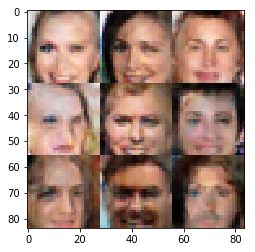

Epoch 1/2 - D_loss:0.8060 | G_loss:0.9522
Epoch 1/2 - D_loss:2.3264 | G_loss:0.2494
Epoch 1/2 - D_loss:1.7714 | G_loss:0.4199
Epoch 1/2 - D_loss:0.6523 | G_loss:1.1548
Epoch 1/2 - D_loss:1.2677 | G_loss:2.7836
Epoch 1/2 - D_loss:1.2728 | G_loss:1.8178
Epoch 1/2 - D_loss:0.5498 | G_loss:1.4442
Epoch 1/2 - D_loss:1.8371 | G_loss:0.3290
Epoch 1/2 - D_loss:0.7937 | G_loss:1.1435
Epoch 1/2 - D_loss:1.5624 | G_loss:0.5092


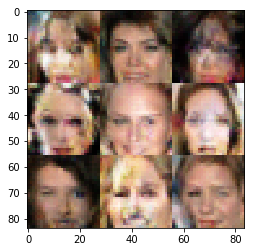

Epoch 1/2 - D_loss:1.2378 | G_loss:0.8118
Epoch 1/2 - D_loss:1.7711 | G_loss:0.4248
Epoch 1/2 - D_loss:0.6640 | G_loss:1.2902
Epoch 1/2 - D_loss:1.4093 | G_loss:0.8602
Epoch 1/2 - D_loss:1.0149 | G_loss:0.9679
Epoch 1/2 - D_loss:0.6217 | G_loss:1.3299
Epoch 1/2 - D_loss:1.3535 | G_loss:0.7070
Epoch 1/2 - D_loss:2.4574 | G_loss:0.1745
Epoch 1/2 - D_loss:0.4700 | G_loss:1.3371
Epoch 1/2 - D_loss:2.3984 | G_loss:0.2340


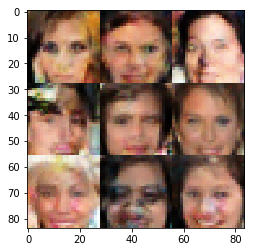

Epoch 1/2 - D_loss:1.3472 | G_loss:2.0176
Epoch 1/2 - D_loss:0.2756 | G_loss:1.9994
Epoch 1/2 - D_loss:1.1040 | G_loss:0.6686
Epoch 1/2 - D_loss:0.5315 | G_loss:1.7259
Epoch 1/2 - D_loss:2.1339 | G_loss:0.2365
Epoch 1/2 - D_loss:1.2797 | G_loss:0.6307
Epoch 1/2 - D_loss:1.1390 | G_loss:0.9748
Epoch 1/2 - D_loss:1.1627 | G_loss:0.7589
Epoch 1/2 - D_loss:1.7885 | G_loss:0.3545
Epoch 1/2 - D_loss:2.5492 | G_loss:0.1770


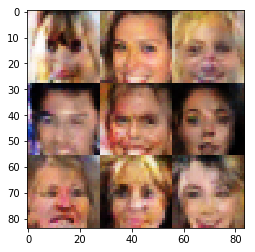

Epoch 1/2 - D_loss:1.7248 | G_loss:0.3532
Epoch 1/2 - D_loss:1.5396 | G_loss:0.4815
Epoch 1/2 - D_loss:0.9330 | G_loss:0.9031
Epoch 1/2 - D_loss:0.8094 | G_loss:1.2139
Epoch 1/2 - D_loss:1.4020 | G_loss:0.4953
Epoch 1/2 - D_loss:1.8250 | G_loss:0.3429
Epoch 2/2 - D_loss:1.6630 | G_loss:0.4360
Epoch 2/2 - D_loss:1.2699 | G_loss:0.6491
Epoch 2/2 - D_loss:1.9280 | G_loss:0.3702
Epoch 2/2 - D_loss:1.0767 | G_loss:0.9645


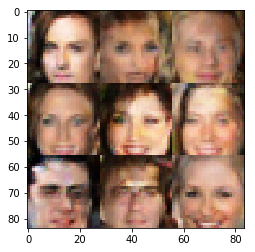

Epoch 2/2 - D_loss:1.2469 | G_loss:0.6984
Epoch 2/2 - D_loss:1.3892 | G_loss:1.7252
Epoch 2/2 - D_loss:0.8590 | G_loss:1.0348
Epoch 2/2 - D_loss:1.2705 | G_loss:0.5679
Epoch 2/2 - D_loss:0.8452 | G_loss:1.0503
Epoch 2/2 - D_loss:1.2303 | G_loss:0.6801
Epoch 2/2 - D_loss:2.9853 | G_loss:0.1499
Epoch 2/2 - D_loss:0.9434 | G_loss:1.1105
Epoch 2/2 - D_loss:0.8785 | G_loss:1.4275
Epoch 2/2 - D_loss:2.0014 | G_loss:0.2978


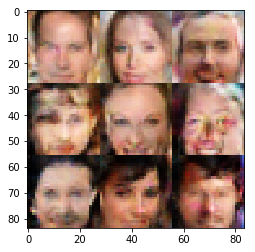

Epoch 2/2 - D_loss:1.7303 | G_loss:0.3556
Epoch 2/2 - D_loss:1.2976 | G_loss:0.7077
Epoch 2/2 - D_loss:1.5060 | G_loss:0.5382
Epoch 2/2 - D_loss:1.2590 | G_loss:0.5800
Epoch 2/2 - D_loss:1.0590 | G_loss:0.6593
Epoch 2/2 - D_loss:0.9890 | G_loss:0.8325
Epoch 2/2 - D_loss:1.1919 | G_loss:0.5802
Epoch 2/2 - D_loss:1.2247 | G_loss:0.6392
Epoch 2/2 - D_loss:1.2107 | G_loss:0.6587
Epoch 2/2 - D_loss:1.0162 | G_loss:1.4613


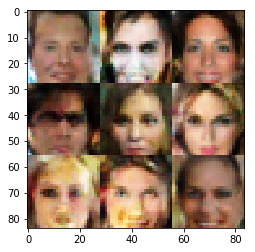

Epoch 2/2 - D_loss:1.2621 | G_loss:1.7089
Epoch 2/2 - D_loss:2.1156 | G_loss:0.3132
Epoch 2/2 - D_loss:1.9473 | G_loss:0.3448
Epoch 2/2 - D_loss:1.4327 | G_loss:0.6278
Epoch 2/2 - D_loss:1.5668 | G_loss:0.3888
Epoch 2/2 - D_loss:1.7597 | G_loss:0.3771
Epoch 2/2 - D_loss:1.6606 | G_loss:0.4308
Epoch 2/2 - D_loss:1.1034 | G_loss:0.9987
Epoch 2/2 - D_loss:1.6587 | G_loss:0.3848
Epoch 2/2 - D_loss:2.6472 | G_loss:0.1890


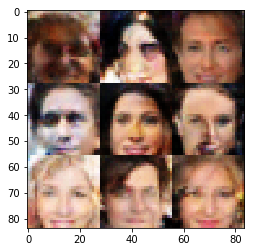

Epoch 2/2 - D_loss:1.5489 | G_loss:0.4335
Epoch 2/2 - D_loss:1.8930 | G_loss:0.3372
Epoch 2/2 - D_loss:1.6006 | G_loss:0.4707
Epoch 2/2 - D_loss:1.0808 | G_loss:0.6819
Epoch 2/2 - D_loss:1.3079 | G_loss:0.5763
Epoch 2/2 - D_loss:1.1490 | G_loss:0.7330
Epoch 2/2 - D_loss:2.1656 | G_loss:0.2133
Epoch 2/2 - D_loss:1.0118 | G_loss:0.8594
Epoch 2/2 - D_loss:1.6808 | G_loss:0.4104
Epoch 2/2 - D_loss:1.5504 | G_loss:0.4768


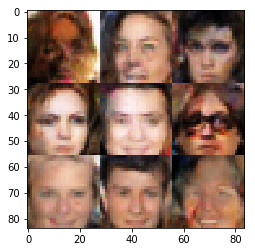

Epoch 2/2 - D_loss:1.2692 | G_loss:1.9453
Epoch 2/2 - D_loss:1.7085 | G_loss:0.4172
Epoch 2/2 - D_loss:1.0139 | G_loss:1.4818
Epoch 2/2 - D_loss:1.1559 | G_loss:0.7462
Epoch 2/2 - D_loss:1.2278 | G_loss:0.6652
Epoch 2/2 - D_loss:1.1227 | G_loss:0.6819
Epoch 2/2 - D_loss:0.9847 | G_loss:0.9329
Epoch 2/2 - D_loss:2.0988 | G_loss:0.3254
Epoch 2/2 - D_loss:0.8537 | G_loss:0.8989
Epoch 2/2 - D_loss:1.4179 | G_loss:0.6755


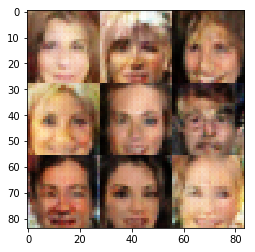

Epoch 2/2 - D_loss:1.0236 | G_loss:0.6948
Epoch 2/2 - D_loss:1.1123 | G_loss:0.8653
Epoch 2/2 - D_loss:1.8556 | G_loss:0.3985
Epoch 2/2 - D_loss:0.5796 | G_loss:1.3256
Epoch 2/2 - D_loss:2.2962 | G_loss:2.6060
Epoch 2/2 - D_loss:1.4365 | G_loss:0.4828
Epoch 2/2 - D_loss:1.1558 | G_loss:1.7158
Epoch 2/2 - D_loss:0.8849 | G_loss:1.8993
Epoch 2/2 - D_loss:2.2287 | G_loss:0.3197
Epoch 2/2 - D_loss:0.6047 | G_loss:1.2243


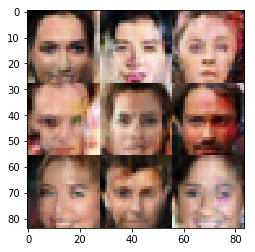

Epoch 2/2 - D_loss:0.3357 | G_loss:1.7706
Epoch 2/2 - D_loss:0.3138 | G_loss:2.4112
Epoch 2/2 - D_loss:1.0796 | G_loss:0.7440
Epoch 2/2 - D_loss:0.1458 | G_loss:2.7460
Epoch 2/2 - D_loss:1.8222 | G_loss:2.3787
Epoch 2/2 - D_loss:1.8101 | G_loss:0.4105
Epoch 2/2 - D_loss:1.4098 | G_loss:0.5487
Epoch 2/2 - D_loss:0.9824 | G_loss:0.9004
Epoch 2/2 - D_loss:2.1274 | G_loss:2.5298
Epoch 2/2 - D_loss:1.2124 | G_loss:0.7153


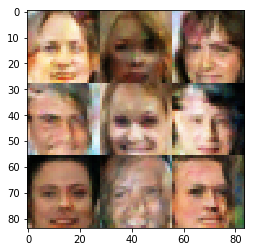

Epoch 2/2 - D_loss:0.7038 | G_loss:1.3107
Epoch 2/2 - D_loss:1.5305 | G_loss:0.4960
Epoch 2/2 - D_loss:0.3759 | G_loss:2.1713
Epoch 2/2 - D_loss:0.1401 | G_loss:3.8552
Epoch 2/2 - D_loss:0.1728 | G_loss:3.3716
Epoch 2/2 - D_loss:2.2201 | G_loss:0.3922
Epoch 2/2 - D_loss:0.8865 | G_loss:1.5733
Epoch 2/2 - D_loss:1.8031 | G_loss:0.4400
Epoch 2/2 - D_loss:2.1175 | G_loss:0.3141
Epoch 2/2 - D_loss:0.9663 | G_loss:1.2756


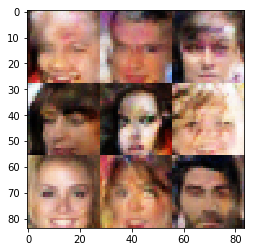

Epoch 2/2 - D_loss:1.2538 | G_loss:1.5544
Epoch 2/2 - D_loss:2.1722 | G_loss:0.3702
Epoch 2/2 - D_loss:0.8222 | G_loss:1.0737
Epoch 2/2 - D_loss:0.9319 | G_loss:0.9244
Epoch 2/2 - D_loss:2.8263 | G_loss:0.1866
Epoch 2/2 - D_loss:2.0120 | G_loss:0.4097
Epoch 2/2 - D_loss:0.8000 | G_loss:1.2331
Epoch 2/2 - D_loss:2.6550 | G_loss:0.2222
Epoch 2/2 - D_loss:0.9437 | G_loss:0.9188
Epoch 2/2 - D_loss:1.0841 | G_loss:0.7715


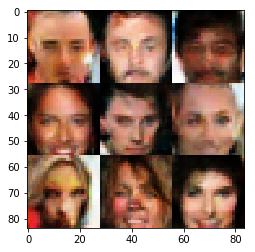

Epoch 2/2 - D_loss:1.4629 | G_loss:0.5431
Epoch 2/2 - D_loss:0.8978 | G_loss:1.1078
Epoch 2/2 - D_loss:1.9474 | G_loss:0.3359
Epoch 2/2 - D_loss:2.1750 | G_loss:0.3056
Epoch 2/2 - D_loss:2.1162 | G_loss:0.3229
Epoch 2/2 - D_loss:1.1820 | G_loss:0.7628
Epoch 2/2 - D_loss:0.9167 | G_loss:1.4238
Epoch 2/2 - D_loss:1.3444 | G_loss:0.6246
Epoch 2/2 - D_loss:1.0359 | G_loss:0.9800
Epoch 2/2 - D_loss:2.7683 | G_loss:0.2087


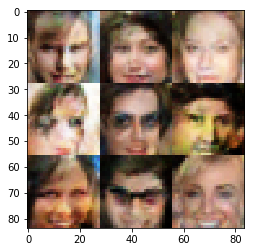

Epoch 2/2 - D_loss:2.4783 | G_loss:0.2989
Epoch 2/2 - D_loss:1.7464 | G_loss:0.4100
Epoch 2/2 - D_loss:1.5239 | G_loss:0.5249
Epoch 2/2 - D_loss:0.8791 | G_loss:1.2743
Epoch 2/2 - D_loss:1.1109 | G_loss:0.6963
Epoch 2/2 - D_loss:2.8178 | G_loss:0.1857
Epoch 2/2 - D_loss:2.2409 | G_loss:0.3318
Epoch 2/2 - D_loss:1.2562 | G_loss:0.7062
Epoch 2/2 - D_loss:2.2596 | G_loss:0.2976
Epoch 2/2 - D_loss:2.0721 | G_loss:0.4009


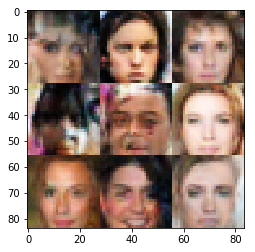

Epoch 2/2 - D_loss:2.7574 | G_loss:0.2008
Epoch 2/2 - D_loss:1.0386 | G_loss:1.2004
Epoch 2/2 - D_loss:1.4069 | G_loss:0.5383
Epoch 2/2 - D_loss:2.0693 | G_loss:0.3004
Epoch 2/2 - D_loss:0.9294 | G_loss:1.2073
Epoch 2/2 - D_loss:1.5816 | G_loss:0.4930
Epoch 2/2 - D_loss:0.9764 | G_loss:1.2962
Epoch 2/2 - D_loss:0.7647 | G_loss:1.3867
Epoch 2/2 - D_loss:0.9786 | G_loss:0.8091
Epoch 2/2 - D_loss:1.0201 | G_loss:0.8446


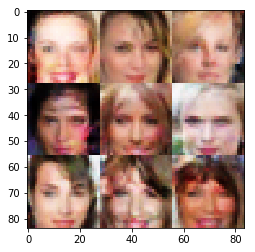

Epoch 2/2 - D_loss:1.1016 | G_loss:0.7296
Epoch 2/2 - D_loss:1.0048 | G_loss:1.0579
Epoch 2/2 - D_loss:0.9607 | G_loss:0.9728
Epoch 2/2 - D_loss:2.2943 | G_loss:0.2667
Epoch 2/2 - D_loss:1.9277 | G_loss:0.3638
Epoch 2/2 - D_loss:0.9254 | G_loss:1.0215
Epoch 2/2 - D_loss:1.5637 | G_loss:1.9480
Epoch 2/2 - D_loss:1.2752 | G_loss:0.6292
Epoch 2/2 - D_loss:1.8116 | G_loss:0.5083
Epoch 2/2 - D_loss:2.0669 | G_loss:0.3714


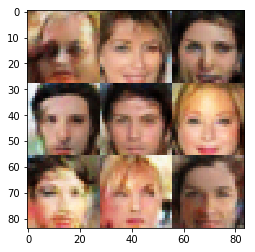

Epoch 2/2 - D_loss:0.9229 | G_loss:1.1113
Epoch 2/2 - D_loss:1.0775 | G_loss:0.7469
Epoch 2/2 - D_loss:1.5448 | G_loss:0.5018
Epoch 2/2 - D_loss:1.7869 | G_loss:0.3645
Epoch 2/2 - D_loss:0.6924 | G_loss:1.1632
Epoch 2/2 - D_loss:1.3354 | G_loss:1.7410
Epoch 2/2 - D_loss:1.4888 | G_loss:0.5435
Epoch 2/2 - D_loss:1.3767 | G_loss:0.6063
Epoch 2/2 - D_loss:1.8378 | G_loss:0.3529
Epoch 2/2 - D_loss:1.6157 | G_loss:0.5213


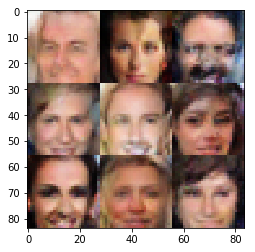

Epoch 2/2 - D_loss:1.1072 | G_loss:0.8723
Epoch 2/2 - D_loss:1.0216 | G_loss:0.8100
Epoch 2/2 - D_loss:1.6400 | G_loss:1.8290
Epoch 2/2 - D_loss:1.1562 | G_loss:0.6954
Epoch 2/2 - D_loss:1.3393 | G_loss:0.5193
Epoch 2/2 - D_loss:1.1977 | G_loss:0.6916
Epoch 2/2 - D_loss:2.6258 | G_loss:0.2297
Epoch 2/2 - D_loss:1.1174 | G_loss:0.6949
Epoch 2/2 - D_loss:2.8589 | G_loss:0.1439
Epoch 2/2 - D_loss:0.8312 | G_loss:1.0318


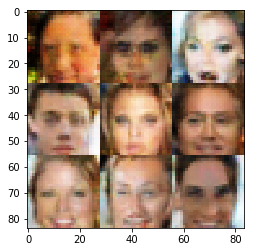

Epoch 2/2 - D_loss:2.0707 | G_loss:0.3461
Epoch 2/2 - D_loss:0.9581 | G_loss:0.8219
Epoch 2/2 - D_loss:0.4820 | G_loss:1.4753
Epoch 2/2 - D_loss:1.1404 | G_loss:1.3205
Epoch 2/2 - D_loss:0.9001 | G_loss:0.8471
Epoch 2/2 - D_loss:0.3776 | G_loss:1.7082
Epoch 2/2 - D_loss:0.8730 | G_loss:1.1661
Epoch 2/2 - D_loss:0.2258 | G_loss:2.4003
Epoch 2/2 - D_loss:2.6234 | G_loss:0.2123
Epoch 2/2 - D_loss:0.1100 | G_loss:4.0673


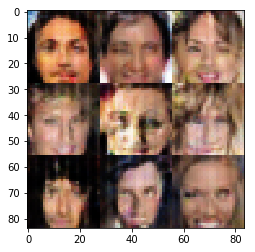

Epoch 2/2 - D_loss:0.6436 | G_loss:5.6331
Epoch 2/2 - D_loss:0.6677 | G_loss:1.3561
Epoch 2/2 - D_loss:2.0697 | G_loss:0.4016
Epoch 2/2 - D_loss:1.3690 | G_loss:0.6729
Epoch 2/2 - D_loss:1.0908 | G_loss:0.7840
Epoch 2/2 - D_loss:0.6521 | G_loss:1.5226
Epoch 2/2 - D_loss:0.8614 | G_loss:1.0223
Epoch 2/2 - D_loss:1.2875 | G_loss:0.5707
Epoch 2/2 - D_loss:1.0478 | G_loss:0.8633
Epoch 2/2 - D_loss:3.4232 | G_loss:0.0819


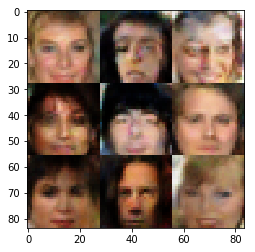

Epoch 2/2 - D_loss:0.8035 | G_loss:1.0969
Epoch 2/2 - D_loss:0.9413 | G_loss:1.7899
Epoch 2/2 - D_loss:0.7994 | G_loss:1.2331
Epoch 2/2 - D_loss:1.2857 | G_loss:0.5851
Epoch 2/2 - D_loss:1.2113 | G_loss:0.6669
Epoch 2/2 - D_loss:2.0037 | G_loss:0.3198
Epoch 2/2 - D_loss:1.3598 | G_loss:0.5306
Epoch 2/2 - D_loss:2.0964 | G_loss:0.3569
Epoch 2/2 - D_loss:2.6315 | G_loss:0.2091
Epoch 2/2 - D_loss:1.4171 | G_loss:0.5222


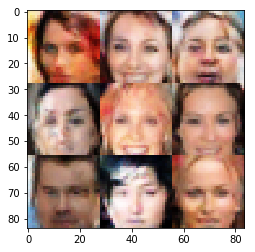

Epoch 2/2 - D_loss:2.1950 | G_loss:0.2826
Epoch 2/2 - D_loss:1.0930 | G_loss:1.6557
Epoch 2/2 - D_loss:2.8239 | G_loss:0.1488
Epoch 2/2 - D_loss:1.0914 | G_loss:0.6951
Epoch 2/2 - D_loss:1.6404 | G_loss:0.4448
Epoch 2/2 - D_loss:1.7590 | G_loss:0.3751
Epoch 2/2 - D_loss:1.6861 | G_loss:0.4151
Epoch 2/2 - D_loss:0.9393 | G_loss:0.9050
Epoch 2/2 - D_loss:1.0930 | G_loss:0.6728
Epoch 2/2 - D_loss:1.0302 | G_loss:0.7508


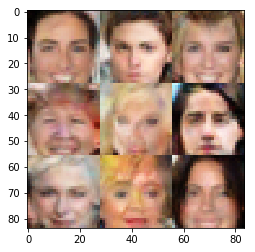

Epoch 2/2 - D_loss:2.1410 | G_loss:2.3090
Epoch 2/2 - D_loss:1.0230 | G_loss:0.8268
Epoch 2/2 - D_loss:0.8656 | G_loss:1.0344
Epoch 2/2 - D_loss:1.5837 | G_loss:0.5009
Epoch 2/2 - D_loss:0.9723 | G_loss:0.9835
Epoch 2/2 - D_loss:1.0285 | G_loss:0.7754
Epoch 2/2 - D_loss:1.8977 | G_loss:0.3829
Epoch 2/2 - D_loss:1.7348 | G_loss:0.4281
Epoch 2/2 - D_loss:1.2957 | G_loss:0.5924
Epoch 2/2 - D_loss:1.7598 | G_loss:0.4537


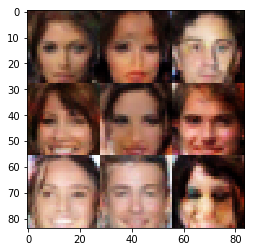

Epoch 2/2 - D_loss:1.8025 | G_loss:0.4293
Epoch 2/2 - D_loss:1.3968 | G_loss:0.4988
Epoch 2/2 - D_loss:1.4570 | G_loss:0.5424
Epoch 2/2 - D_loss:0.9006 | G_loss:1.3520
Epoch 2/2 - D_loss:1.6201 | G_loss:0.4816
Epoch 2/2 - D_loss:1.4804 | G_loss:0.6008
Epoch 2/2 - D_loss:1.5230 | G_loss:0.5289
Epoch 2/2 - D_loss:1.2229 | G_loss:0.6787
Epoch 2/2 - D_loss:2.1463 | G_loss:0.2517
Epoch 2/2 - D_loss:1.3914 | G_loss:0.5720


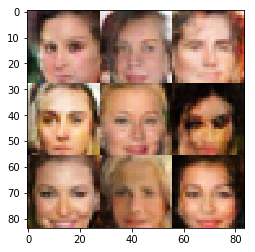

Epoch 2/2 - D_loss:1.6441 | G_loss:0.5891
Epoch 2/2 - D_loss:0.8404 | G_loss:1.5702
Epoch 2/2 - D_loss:1.9126 | G_loss:0.4025
Epoch 2/2 - D_loss:0.8881 | G_loss:0.9746
Epoch 2/2 - D_loss:0.7784 | G_loss:1.5301
Epoch 2/2 - D_loss:1.5632 | G_loss:0.4666
Epoch 2/2 - D_loss:0.9602 | G_loss:1.8169
Epoch 2/2 - D_loss:1.2088 | G_loss:0.6924
Epoch 2/2 - D_loss:1.6518 | G_loss:0.5375
Epoch 2/2 - D_loss:2.5584 | G_loss:0.2387


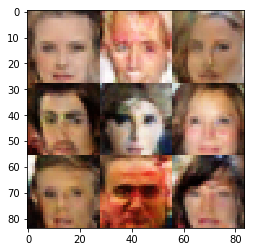

Epoch 2/2 - D_loss:0.8367 | G_loss:1.1319
Epoch 2/2 - D_loss:0.8458 | G_loss:1.1857
Epoch 2/2 - D_loss:0.8653 | G_loss:1.0022
Epoch 2/2 - D_loss:0.9468 | G_loss:0.9775
Epoch 2/2 - D_loss:1.6674 | G_loss:1.9597
Epoch 2/2 - D_loss:1.4404 | G_loss:0.5011
Epoch 2/2 - D_loss:0.9724 | G_loss:0.7762
Epoch 2/2 - D_loss:0.5627 | G_loss:1.7365
Epoch 2/2 - D_loss:1.1319 | G_loss:0.7022
Epoch 2/2 - D_loss:0.9359 | G_loss:0.8698


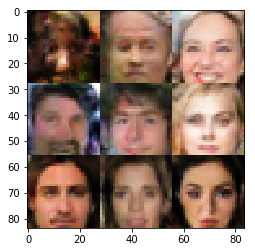

Epoch 2/2 - D_loss:0.7474 | G_loss:1.0652
Epoch 2/2 - D_loss:0.4573 | G_loss:1.9391
Epoch 2/2 - D_loss:1.3977 | G_loss:0.5479
Epoch 2/2 - D_loss:1.1828 | G_loss:0.7067
Epoch 2/2 - D_loss:0.3743 | G_loss:2.0461
Epoch 2/2 - D_loss:0.4515 | G_loss:1.6121
Epoch 2/2 - D_loss:1.0247 | G_loss:0.7770
Epoch 2/2 - D_loss:0.9372 | G_loss:1.5020
Epoch 2/2 - D_loss:0.9265 | G_loss:1.9780
Epoch 2/2 - D_loss:2.8690 | G_loss:0.1928


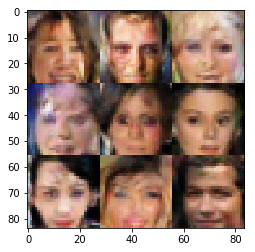

Epoch 2/2 - D_loss:1.4114 | G_loss:0.5894
Epoch 2/2 - D_loss:0.4187 | G_loss:1.8290
Epoch 2/2 - D_loss:1.3711 | G_loss:0.5734
Epoch 2/2 - D_loss:0.9626 | G_loss:0.9465
Epoch 2/2 - D_loss:0.1310 | G_loss:2.9251
Epoch 2/2 - D_loss:0.1323 | G_loss:4.1928
Epoch 2/2 - D_loss:0.0684 | G_loss:5.0524
Epoch 2/2 - D_loss:0.5144 | G_loss:2.9813
Epoch 2/2 - D_loss:0.7723 | G_loss:1.4216
Epoch 2/2 - D_loss:0.9017 | G_loss:1.9965


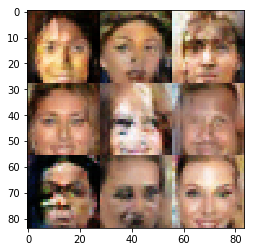

Epoch 2/2 - D_loss:0.8865 | G_loss:2.0951
Epoch 2/2 - D_loss:1.0752 | G_loss:2.3169
Epoch 2/2 - D_loss:0.7955 | G_loss:1.5899
Epoch 2/2 - D_loss:1.9300 | G_loss:0.5056
Epoch 2/2 - D_loss:2.0498 | G_loss:0.4176
Epoch 2/2 - D_loss:0.9262 | G_loss:0.9524
Epoch 2/2 - D_loss:1.1700 | G_loss:2.0389
Epoch 2/2 - D_loss:0.9309 | G_loss:0.9407
Epoch 2/2 - D_loss:2.0427 | G_loss:0.4151
Epoch 2/2 - D_loss:2.0639 | G_loss:0.3996


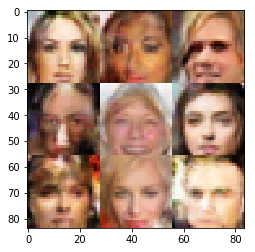

Epoch 2/2 - D_loss:1.8504 | G_loss:0.5309
Epoch 2/2 - D_loss:1.7945 | G_loss:0.4344
Epoch 2/2 - D_loss:0.8653 | G_loss:1.0397
Epoch 2/2 - D_loss:1.6406 | G_loss:0.5725
Epoch 2/2 - D_loss:2.1297 | G_loss:0.4013
Epoch 2/2 - D_loss:0.8587 | G_loss:1.1014
Epoch 2/2 - D_loss:0.8283 | G_loss:1.2017
Epoch 2/2 - D_loss:2.5294 | G_loss:0.2471
Epoch 2/2 - D_loss:2.0819 | G_loss:0.3485
Epoch 2/2 - D_loss:1.7557 | G_loss:0.4266


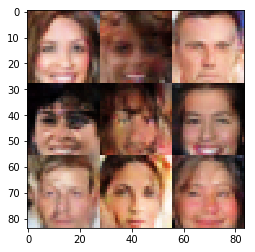

Epoch 2/2 - D_loss:0.9335 | G_loss:0.8557
Epoch 2/2 - D_loss:1.0082 | G_loss:0.8979
Epoch 2/2 - D_loss:1.3577 | G_loss:0.6648
Epoch 2/2 - D_loss:0.8756 | G_loss:1.2516
Epoch 2/2 - D_loss:1.7153 | G_loss:0.4697
Epoch 2/2 - D_loss:0.8967 | G_loss:1.4337
Epoch 2/2 - D_loss:1.6001 | G_loss:0.4675
Epoch 2/2 - D_loss:2.3238 | G_loss:0.2759
Epoch 2/2 - D_loss:0.7745 | G_loss:1.1917
Epoch 2/2 - D_loss:1.8338 | G_loss:0.3632


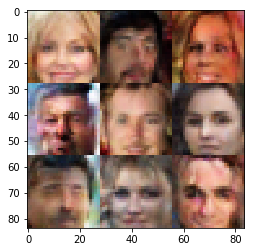

Epoch 2/2 - D_loss:1.1506 | G_loss:1.0768
Epoch 2/2 - D_loss:0.9974 | G_loss:1.7496
Epoch 2/2 - D_loss:1.2588 | G_loss:0.7143
Epoch 2/2 - D_loss:1.3736 | G_loss:0.5474
Epoch 2/2 - D_loss:1.1108 | G_loss:0.7898
Epoch 2/2 - D_loss:2.5914 | G_loss:0.2771
Epoch 2/2 - D_loss:0.8374 | G_loss:1.2071
Epoch 2/2 - D_loss:1.1248 | G_loss:0.7854
Epoch 2/2 - D_loss:1.7089 | G_loss:0.4519
Epoch 2/2 - D_loss:1.3813 | G_loss:0.5428


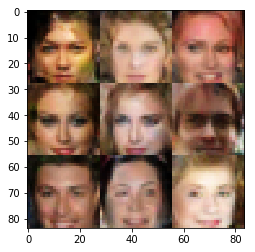

Epoch 2/2 - D_loss:0.9361 | G_loss:1.1259
Epoch 2/2 - D_loss:1.2575 | G_loss:0.5938
Epoch 2/2 - D_loss:1.0186 | G_loss:0.9935
Epoch 2/2 - D_loss:2.0990 | G_loss:0.4075
Epoch 2/2 - D_loss:1.2700 | G_loss:1.6147
Epoch 2/2 - D_loss:1.0989 | G_loss:0.7641
Epoch 2/2 - D_loss:1.2298 | G_loss:0.6990
Epoch 2/2 - D_loss:0.8992 | G_loss:1.3970
Epoch 2/2 - D_loss:0.9448 | G_loss:0.9723
Epoch 2/2 - D_loss:0.8755 | G_loss:1.2732


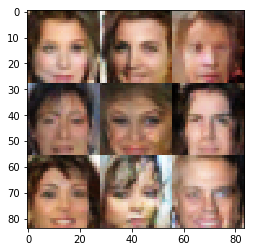

Epoch 2/2 - D_loss:0.9020 | G_loss:1.3606
Epoch 2/2 - D_loss:1.4602 | G_loss:0.7783
Epoch 2/2 - D_loss:2.8558 | G_loss:0.1923
Epoch 2/2 - D_loss:1.5966 | G_loss:0.4573
Epoch 2/2 - D_loss:1.0825 | G_loss:0.8681
Epoch 2/2 - D_loss:1.1842 | G_loss:0.7207
Epoch 2/2 - D_loss:0.9919 | G_loss:0.9692
Epoch 2/2 - D_loss:0.8714 | G_loss:0.9804
Epoch 2/2 - D_loss:1.7484 | G_loss:0.5020
Epoch 2/2 - D_loss:2.0835 | G_loss:0.3191


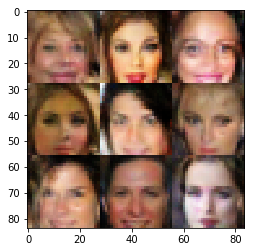

Epoch 2/2 - D_loss:0.7502 | G_loss:1.0415
Epoch 2/2 - D_loss:0.8602 | G_loss:1.2845
Epoch 2/2 - D_loss:0.9463 | G_loss:0.8837


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

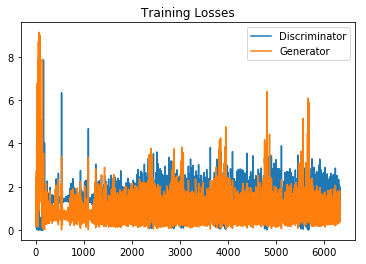

In [20]:
# plot losses for g and d for faces
fig, ax = plt.subplots()
losses = np.array(losses_global)

plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.